In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.neighbors import KernelDensity

'''
GRAPH CONFIGURATION
'''
sns.set_theme(style='whitegrid')
# import scienceplots
# plt.style.use(['science','ieee'])


first_flag = True
roi_flag = True
length = 0
prev = None

frame_idx = 0
roi = [0, 0, 0, 0]

'''
CIRCULAR MASK VARIABLES
'''
center_of_roi = [0, 0]
transposed_pos = [0, 0]
mask = np.nan
first_flag_cnt = 0

flow_frame = []

grad_dists = []
percentile_grad_dists = []
# Path to the tiff file

path = "raw_data/Basil_sample2_9/Basil_15_50fps_binning2_sample2(9).tif"
# List to store the loaded image
images = []

ret, images = cv2.imreadmulti(mats=images,
                              filename=path,
                              flags=cv2.IMREAD_GRAYSCALE)

idx = 0

images = images[::5]

In [2]:
def drawFlow(img, flow, step=1, filtering=True, save_data=False):
    global min_dist, frame_idx
    plot_img = None

    h, w = flow.shape[:2]

    idx_y, idx_x = np.mgrid[step / 2:h:step, step / 2:w:step].astype(int)
    indicies = np.stack((idx_x, idx_y), axis=-1).reshape(-1, 2)

    if filtering:
        min_dist = find_optical_distance(flow, 80, h)
        print(min_dist)

    for x, y in indicies:
        dy, dx = flow[y, x].astype(int)

        if filtering and np.sqrt(dx ** 2 + dy ** 2) > min_dist:
            # print(min_dist)
            # x += transposed_pos[0]
            # y += transposed_pos[1]
            cv2.circle(img, (x, y), 1, (0, 255, 0), -1)
            plot_img = cv2.arrowedLine(img, (x, y), (x + dx, y + dy), (0, 255, 0), 1, cv2.LINE_AA)


        elif filtering is False:
            cv2.circle(img, (x, y), 1, (0, 255, 0), -1)
            cv2.arrowedLine(img, (x, y), (x + dx, y + dy), (0, 255, 0), 1, cv2.LINE_AA)

    if plot_img is not None and save_data is True:
        plt.imsave(f'../processed/with_gaussian/0913/farneback{frame_idx}.png', plot_img)

    frame_idx += 1

In [3]:
def masking_circle(unmask_frame):
    result_image = cv2.bitwise_and(unmask_frame, unmask_frame, mask=mask)

    return result_image


In [4]:
def visualizae_flow(flows):
    diags_x = []
    diags_y = []
    diags = []

    for flow in flows:
        diag = []
        y = flow[:, :, 0]
        x = flow[:, :, 1]

        for i in range(len(y)):

            angle = np.arctan2(y[i][i], x[i][i])
            if angle != 0:
                diag.append(angle)

        diags.append(diag)

        # ax = sns.histplot(x=diag,
        #                  color='r',  ## 색상
        #                  bins=30,  ## bin 개수
        #                  kde=True,  ## 밀도 함수 곡선 추가
        #                  element='step',  ## 히스토그램 표시형식,
        #                  stat='percent',  ## y값 계산 방식 count
        #                  cumulative=False,  ## True인 경우 누적 분포 형태로 그림
        #                  )

        # plt.show()


In [20]:
def find_optical_distance(pixel_dist, percent, pixel_size):
    global first_flag, first_flag_cnt
    dists = []
    for i in range(pixel_size):
        for j in range(pixel_size):
            dists.append(np.sqrt(pixel_dist[i][j][0] ** 2 + pixel_dist[i][j][1] ** 2))

    if first_flag < 5 and True:
        plt.plot(dists)
        dists = np.array(dists).reshape(-1, 1)
        plt.show()

        first_flag = False

        kde = KernelDensity(bandwidth=1, kernel='gaussian')
        kde.fit(dists)

        # x 범위 생성
        x = np.linspace(min(dists), max(dists), 1000).reshape(-1, 1)

        # KDE 계산
        log_density = kde.score_samples(x)

        # 시각화
        plt.plot(x, np.exp(log_density), label='KDE')
        plt.scatter(dists, np.zeros_like(dists), color='red', label='Data Points')
        plt.title('Kernel Density Estimation')
        plt.xlabel('x')
        plt.ylabel('Probability Density')
        plt.legend()
        plt.grid(True)
        plt.show()

        first_flag_cnt += 1

    dists = np.array(dists)
    percentile = np.percentile(dists, percent)
    filtered_dist = dists[dists >= percentile]

    grad_dists.append(np.average(dists))
    percentile_grad_dists.append(np.average(filtered_dist))
    print("-----------")
    print(np.average(grad_dists))
    print(np.average(percentile_grad_dists))
    print("-----------")

    #plt.plot(dists)
    #plt.show()


    return percentile


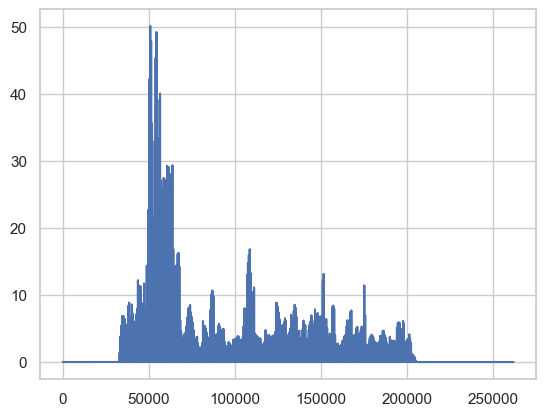

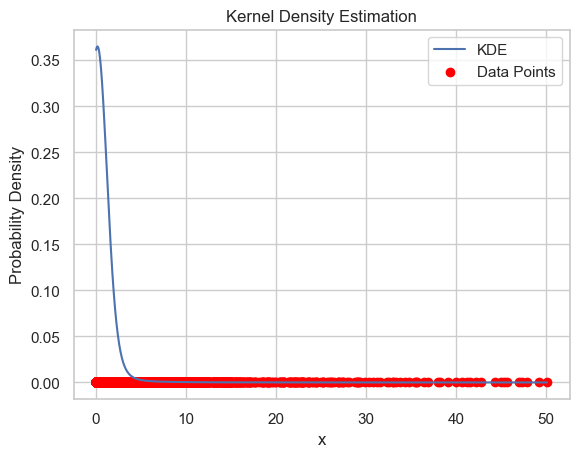

-----------
0.15528571471849228
0.6793632996347169
-----------
0.46314598829619336


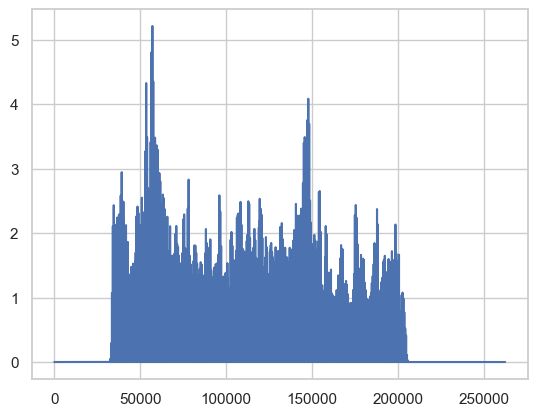

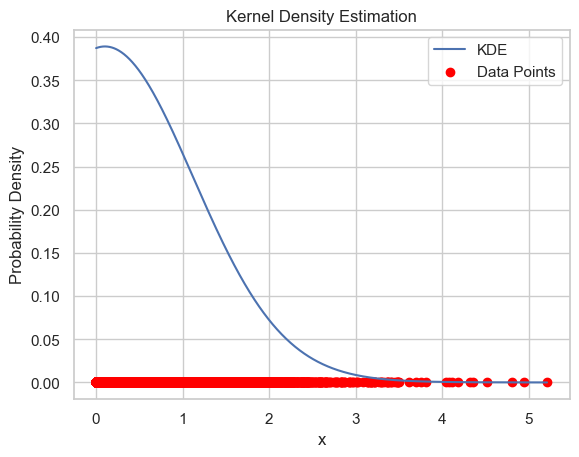

-----------
0.15496771423554886
0.6778978752230985
-----------
0.21756803638532782


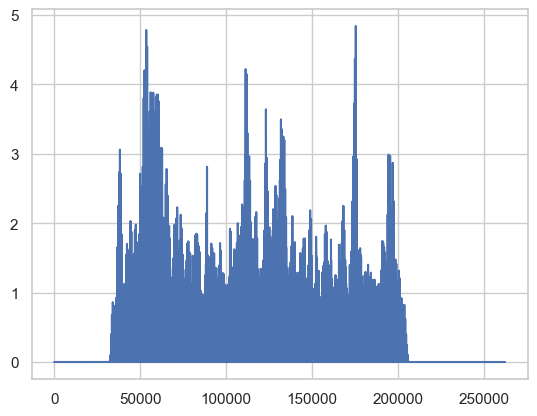

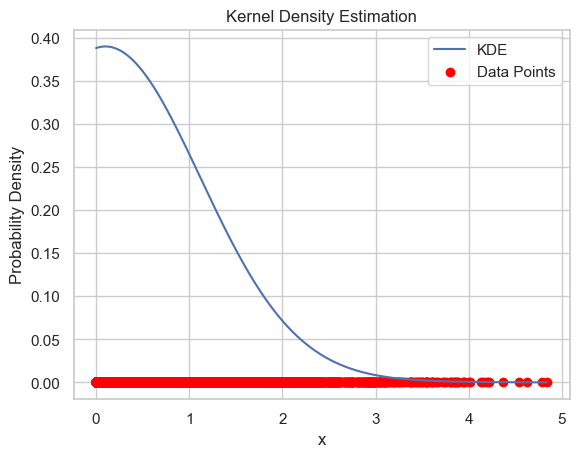

-----------
0.15463450068133505
0.6763430653438833
-----------
0.2179773554073172


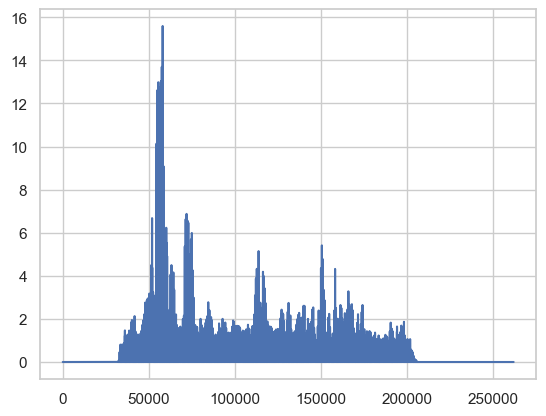

KeyboardInterrupt: 

In [21]:
test_idx = 0

for image in images:

    '''
    Image Contrast Calculation
    '''
    image = cv2.add(image, 200)
    image = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX)

    #plt.imshow(image)
    #plt.show()
    frame = image
    gray = frame[:]

    if roi_flag:

        # circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT, 1, 100, param1=70, param2=35, minRadius=100,
        #                           maxRadius=400)

        circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT, 1, 500, param1=100, param2=100, minRadius=100,
                                   maxRadius=400)

        if circles is not None and circles.all():
            for i in circles[0]:
                # roi => (x_1, y_1), (x_2, y_2)
                i[2] = i[2]
                roi = [int(i[0] - i[2]), int(i[1] - i[2]), int(i[0] + i[2]), int(i[1] + i[2])]
                center_of_roi = [(roi[0] + roi[2]) // 2, (roi[1] + roi[3]) // 2]

                # transposed_pos => (x_1, y_1)
                transposed_pos = [roi[0], roi[1]]
                mask = np.zeros(gray.shape[:2], dtype=np.uint8)
                mask = cv2.circle(mask, (int(i[0]), int(i[1])), int(i[2]) - 20, (255, 255, 255), -1)

                masked_image = masking_circle(gray)

                '''
                FOR DEBUG
                '''
                cv2.imshow('OpticalFlow-Farneback1', masked_image)
                if cv2.waitKey() == 27:
                    break
                '''
                '''
                break
            roi_flag = False

    else:
        # gray = gray[roi[0]:roi[2], roi[1]:roi[3]]
        if prev is None:
            prev = masking_circle(gray)
        else:
            gray = masking_circle(gray)
            gray = cv2.GaussianBlur(gray, (0, 0), 2.0)

            if cv2.waitKey(10) == 27:
                break

            '''
            prev – first 8-bit single-channel input image.
            next – second input image of the same size and the same type as prev.
            flow – computed flow image that has the same size as prev and type CV_32FC2.
            pyr_scale – parameter, specifying the image scale (<1) to build pyramids for each image; pyr_scale=0.5 means a classical pyramid, where each next layer is twice smaller than the previous one.
            levels – number of pyramid layers including the initial image; levels=1 means that no extra layers are created and only the original images are used.
            winsize – averaging window size; larger values increase the algorithm robustness to image noise and give more chances for fast motion detection, but yield more blurred motion field.
            iterations – number of iterations the algorithm does at each pyramid level.
            poly_n – size of the pixel neighborhood used to find polynomial expansion in each pixel; larger values mean that the image will be approximated with smoother surfaces, yielding more robust algorithm and more blurred motion field, typically poly_n =5 or 7.
            poly_sigma – standard deviation of the Gaussian that is used to smooth derivatives used as a basis for the polynomial expansion; for poly_n=5, you can set poly_sigma=1.1, for poly_n=7, a good value would be poly_sigma=1.5.
            '''
            flow = cv2.calcOpticalFlowFarneback(prev, gray, flow=1,
                                                pyr_scale=0.5,
                                                levels=5,
                                                winsize=5,
                                                iterations=7,
                                                poly_n=13,
                                                poly_sigma=1.1,
                                                flags=cv2.OPTFLOW_FARNEBACK_GAUSSIAN)

            drawFlow(frame, flow, step=2, filtering=True)

            flow_frame.append(flow)

            prev = gray

    #cv2.imshow('OpticalFlow-Farneback', frame)
    #if cv2.waitKey(10) == 27:
    #    break

    test_idx += 1

plt.plot(grad_dists[1:])
plt.show()
cv2.destroyAllWindows()


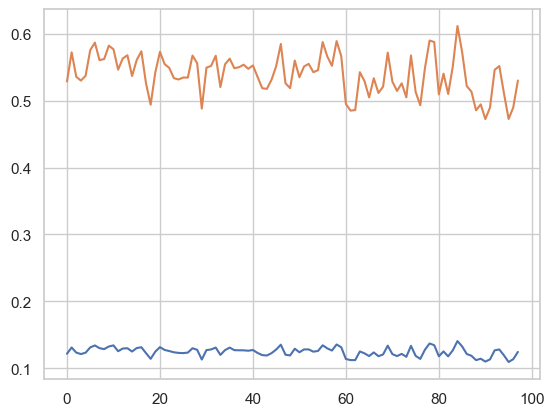

In [7]:
plt.plot(grad_dists[1:])
plt.plot(percentile_grad_dists[1:])

In [8]:
dists = np.array(grad_dists)
percentile_dists = np.array(percentile_grad_dists)

In [9]:
print(np.average(dists[1:]))
print(np.average(percentile_dists[1:]))


0.12475983913103723
0.5397205280297938


In [10]:
np.savetxt("dists_basil(5)_2_9_dist.csv",dists[1:],  delimiter=',')
np.savetxt("dists_basil(5)_80_2_9_dist.csv",percentile_dists[1:],  delimiter=',')

In [14]:
import pandas as pd

In [27]:
df = pd.read_csv("dists_basil(5).csv")
df1 = pd.read_csv("dists_basil(10).csv")
df2 = pd.read_csv("dists_basil_5_1.csv")
df3 = pd.read_csv("dists_basil_15_1.csv")

In [26]:
print(np.average(df[1:]))
print(np.average(df1[1:]))
print(np.average(df2[1:]))
print(np.average(df3[1:]))

0.0739725726392961
0.0751449204833863
0.07035526750989664
0.08432440031987747
